<a href="https://colab.research.google.com/github/bilalProgTech/mtech-nmims/blob/master/deep-learning/Lab-Work/20220807-Lab-4-MTech-DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

kaggle.json file

Steps, Go to your Kaggle Account >  Click on profile > Click on Account > Click on Create API Token

Upload your downloaded kaggle.json file in google colab environment

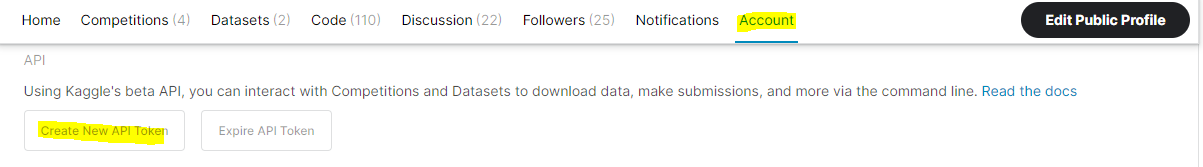

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
!unzip toronto-emotional-speech-set-tess.zip

In [2]:
import tensorflow as tf
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from sklearn.model_selection import train_test_split
import IPython.display as ipd

In [3]:
os.rename('/content/TESS Toronto emotional speech set data', '/content/emotion_speech')

In [ ]:
for dirname, _, filenames in os.walk('/content/emotion_speech'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
ss = '/content/emotion_speech/YAF_neutral/YAF_numb_neutral.wav'
ss.split('/')[-1].replace('.wav', '').split('_')

['YAF', 'numb', 'neutral']

In [6]:
files = []
class_series = []

In [7]:
for dirname, _, filenames in os.walk('/content/emotion_speech'):
    for filename in filenames:
        filepath = os.path.join(dirname, filename)
        files.append(filepath)
        class_series.append(filepath.split('/')[-1].replace('.wav', '').split('_'))

data = pd.DataFrame(class_series, columns=['actress', 'word', 'target'])
data['filename'] = files
data = data.sample(frac=1).reset_index(drop=True) #Shuffle the dataframe
data.head()

,actress,word,target,filename
0,YAF,late,disgust,/content/emotion_speech/YAF_disgust/YAF_late_d...
1,YAF,rough,angry,/content/emotion_speech/YAF_angry/YAF_rough_an...
2,OAF,pearl,happy,/content/emotion_speech/OAF_happy/OAF_pearl_ha...
3,OAF,sail,fear,/content/emotion_speech/OAF_Fear/OAF_sail_fear...
4,OAF,jug,happy,/content/emotion_speech/OAF_happy/OAF_jug_happ...


In [8]:
data['target'].value_counts()

disgust    400
angry      400
happy      400
fear       400
neutral    400
ps         400
sad        400
Name: target, dtype: int64

In [9]:
def get_waveplot(path, target, word, actress):
    x, sr = librosa.load(path)
    plt.figure(figsize=(20, 5))
    librosa.display.waveplot(x, sr=sr)
    plt.title('Waveplot of '+target+' '+actress+' for word '+word)
    plt.show()

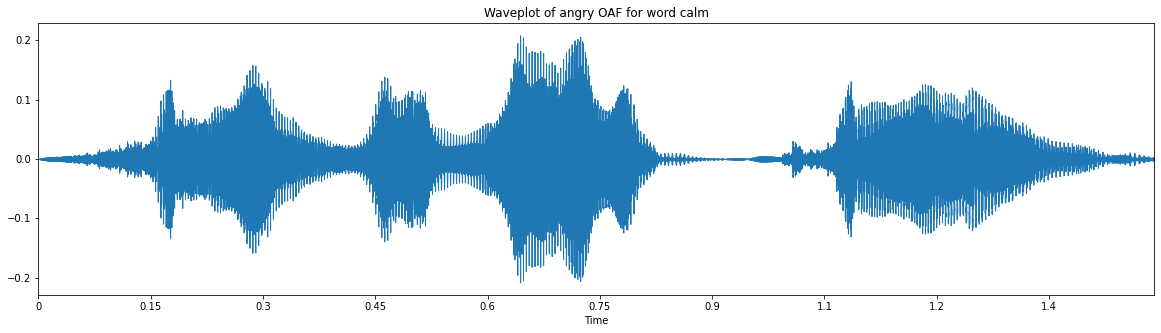

In [10]:
sample = data[(data['target']=='angry') & (data['word']=='calm') & (data['actress']=='OAF')]
get_waveplot(sample['filename'].values[0], sample['target'].values[0], 
             sample['word'].values[0], sample['actress'].values[0])
ipd.Audio(sample['filename'].values[0])

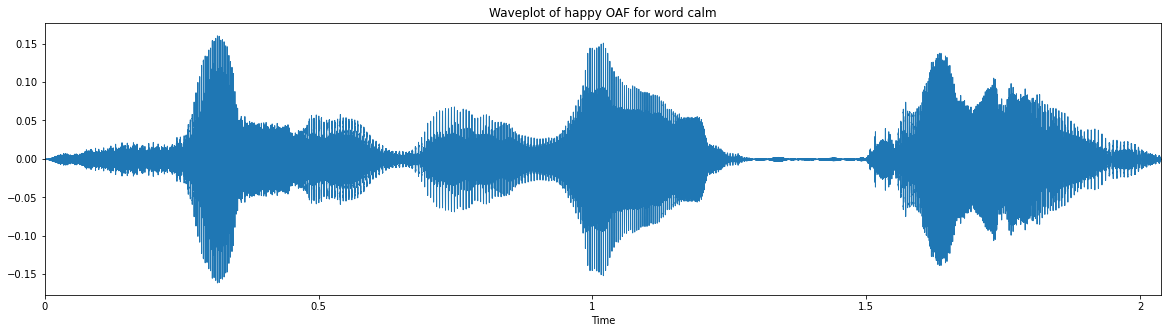

In [11]:
sample = data[(data['target']=='happy') & (data['word']=='calm') & (data['actress']=='OAF')]
get_waveplot(sample['filename'].values[0], sample['target'].values[0], 
             sample['word'].values[0], sample['actress'].values[0])
ipd.Audio(sample['filename'].values[0])

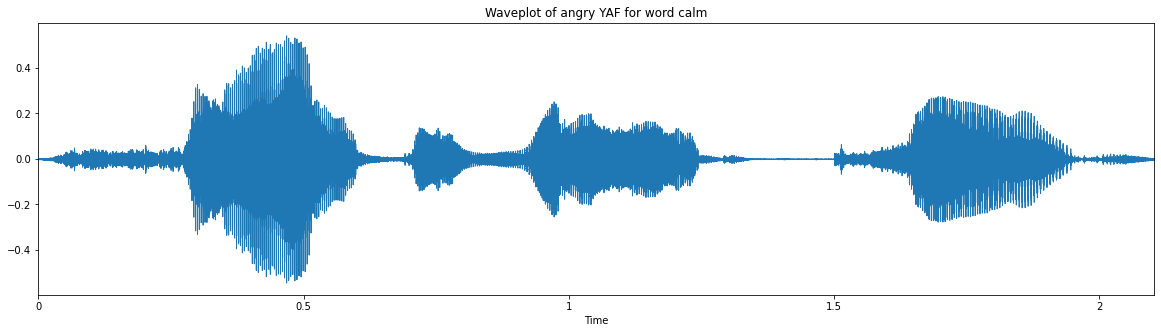

In [12]:
sample = data[(data['target']=='angry') & (data['word']=='calm') & (data['actress']=='YAF')]
get_waveplot(sample['filename'].values[0], sample['target'].values[0], 
             sample['word'].values[0], sample['actress'].values[0])
ipd.Audio(sample['filename'].values[0])

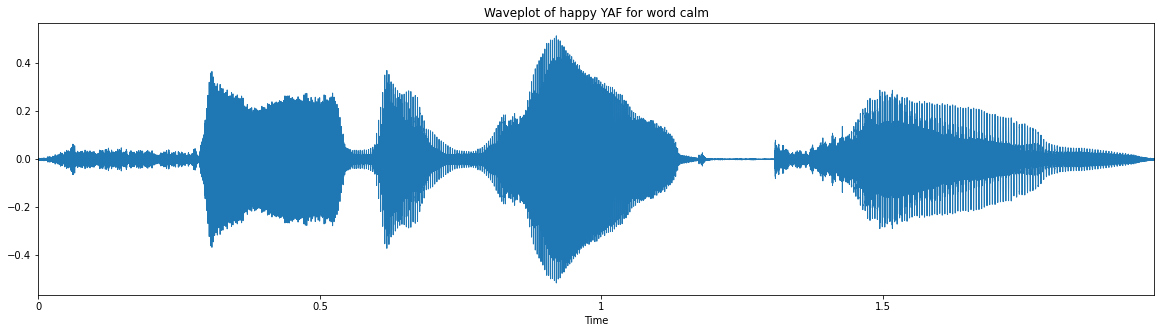

In [13]:
sample = data[(data['target']=='happy') & (data['word']=='calm') & (data['actress']=='YAF')]
get_waveplot(sample['filename'].values[0], sample['target'].values[0], 
             sample['word'].values[0], sample['actress'].values[0])
ipd.Audio(sample['filename'].values[0])

In [14]:
def get_mfcc(path, target, word, actress):
    x, sr = librosa.load(path)
    mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=20)
    print(mfccs.shape)
    plt.figure(figsize=(20, 5))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.title('MFCC Spectral of '+target+' '+actress+' for word '+word)
    plt.show()

(20, 65)


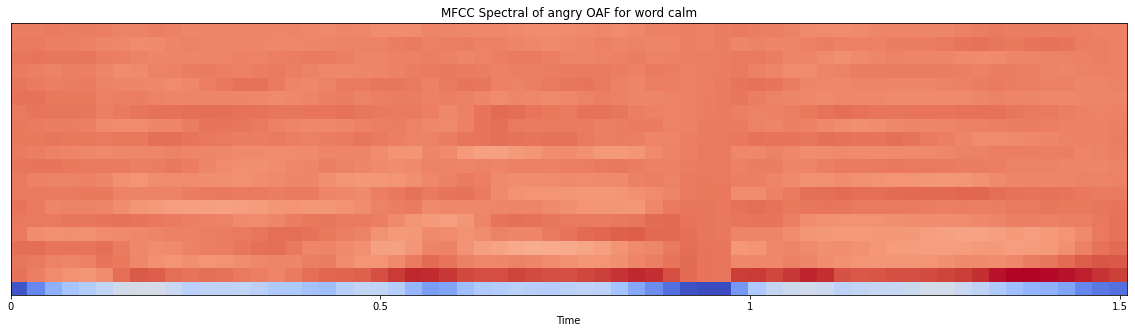

In [15]:
sample = data[(data['target']=='angry') & (data['word']=='calm') & (data['actress']=='OAF')]
get_mfcc(sample['filename'].values[0], sample['target'].values[0], 
             sample['word'].values[0], sample['actress'].values[0])
ipd.Audio(sample['filename'].values[0])

(20, 91)


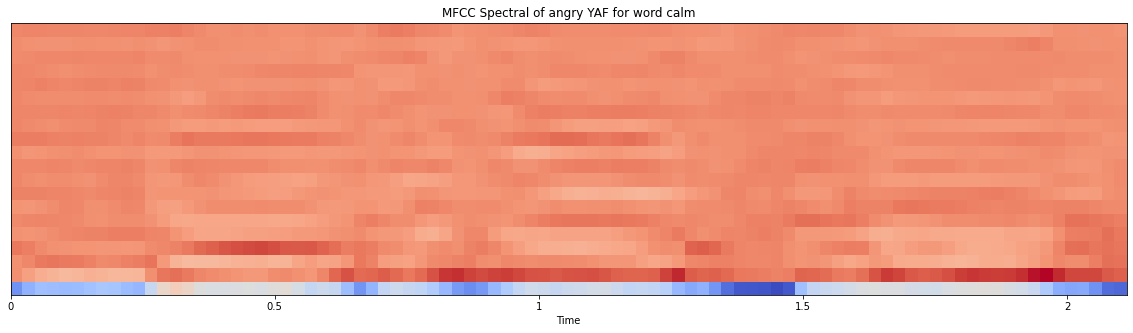

In [16]:
sample = data[(data['target']=='angry') & (data['word']=='calm') & (data['actress']=='YAF')]
get_mfcc(sample['filename'].values[0], sample['target'].values[0], 
             sample['word'].values[0], sample['actress'].values[0])
ipd.Audio(sample['filename'].values[0])

In [17]:
data.shape

(2800, 4)

In [18]:
def get_melspec(path, target, word, actress):
    x, sr = librosa.load(path)
    melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128)
    print(melspec.shape)
    plt.figure(figsize=(20, 5))
    librosa.display.specshow(melspec, sr=sr, x_axis='time')
    plt.title('Mel Spectrogram of '+target+' '+actress+' for word '+word)
    plt.show()

(128, 65)


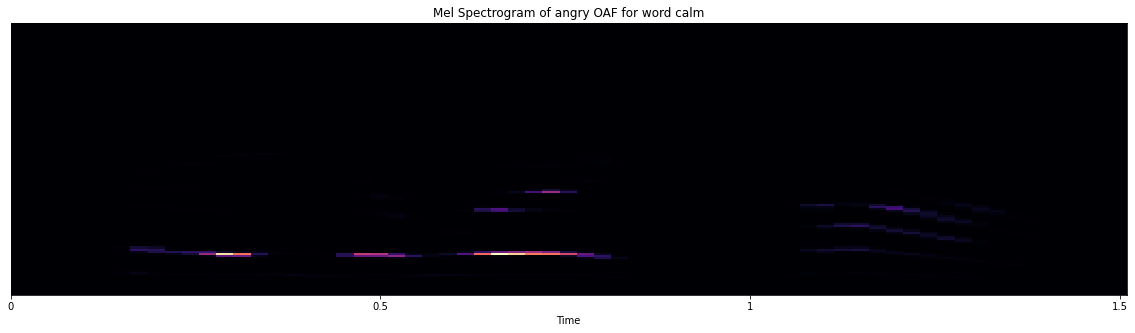

In [19]:
sample = data[(data['target']=='angry') & (data['word']=='calm') & (data['actress']=='OAF')]
get_melspec(sample['filename'].values[0], sample['target'].values[0], 
             sample['word'].values[0], sample['actress'].values[0])
ipd.Audio(sample['filename'].values[0])

(128, 91)


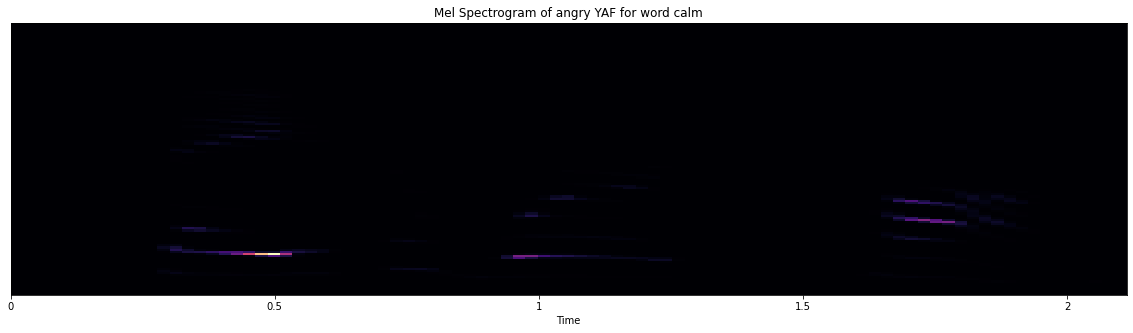

In [20]:
sample = data[(data['target']=='angry') & (data['word']=='calm') & (data['actress']=='YAF')]
get_melspec(sample['filename'].values[0], sample['target'].values[0], 
             sample['word'].values[0], sample['actress'].values[0])
ipd.Audio(sample['filename'].values[0])

# Modelling

## Feature Extraction

In [21]:
def create_mfcc_features(path):
    mfccs = []
    try:
        x, sr = librosa.load(path, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128)
        mfccs = np.mean(mfccs.T, axis=0)
    except:
        print('Error found in audio')
    return mfccs

In [22]:
def create_melspec_features(path):
    melspec = []
    try:
        x, sr = librosa.load(path, res_type='kaiser_fast')
        melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128)
        melspec = np.mean(melspec.T, axis=0)
    except:
        print('Error found in audio')
    return melspec

### Feature Extraction using MFCC

You can try for MelSpec, replace create_mfcc_features to create_melspec_features

In [23]:
%%time

X_df = pd.DataFrame(data['filename'].apply(lambda x: create_mfcc_features(x)).tolist())

CPU times: user 2min 16s, sys: 53.5 s, total: 3min 9s
Wall time: 1min 58s


In [24]:
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-428.096863,56.190453,-2.275338,42.506645,-14.802073,-2.087825,-13.107016,-10.207083,-16.091291,-2.362974,...,0.239652,-0.233791,0.008931,-0.057783,-0.727592,-0.273910,-0.393418,-0.339249,-0.030817,-0.389113
1,-368.925598,45.254448,-1.674407,14.761043,-24.840004,3.408096,-4.581890,-8.153302,-8.800532,0.717713,...,-0.001900,0.520737,0.023697,0.629500,0.468876,-0.107709,0.337951,-0.020180,-0.096446,0.256854
2,-445.458466,86.877983,13.665028,-15.217016,-8.181050,6.547803,-15.949133,-0.372696,-13.650901,-1.621286,...,-0.018502,-0.355630,-0.757994,0.004970,-0.556221,0.227238,0.008289,0.008449,-0.413962,-0.098910
3,-382.065582,39.285480,-1.036875,2.603211,-16.239464,5.286398,-24.337362,2.656389,-24.812464,8.288347,...,-0.406575,-0.345878,-0.378870,-0.365763,-0.208113,0.234895,-0.280908,-0.092160,-0.335525,-0.413144
4,-449.504547,80.600792,11.545651,8.585084,-7.162992,7.050037,-16.865770,1.520064,-18.847015,-0.840083,...,-0.292836,-0.660389,-0.687325,-0.630195,-0.317922,-0.364036,-0.511468,-0.088415,-0.130903,0.169964


In [25]:
X_df.shape

(2800, 128)

In [26]:
encoder = LabelEncoder()
encoder.fit(data['target'])
y = encoder.transform(data['target'])

In [27]:
y

array([1, 0, 3, ..., 5, 4, 2])

In [28]:
x_train, x_val, y_train, y_val = train_test_split(np.array(X_df), y, test_size=0.1)

In [29]:
x_train.shape, x_val.shape

((2520, 128), (280, 128))

In [30]:
x_train = x_train.reshape(x_train.shape[0], 16, 8, 1)
x_val = x_val.reshape(x_val.shape[0], 16, 8, 1)

In [31]:
len(data['target'].unique())

7

## CNN Model

In [32]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(16, 8, 1)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(len(data['target'].unique()), activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 8, 16)         160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 4, 16)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 4, 8)           1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 2, 8)          0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 16)                1

In [33]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.fit(x_train, y_train, epochs=20)

Epoch 1/20
79/79 [==============================] - 12s 4ms/step - loss: 2.2696 - accuracy: 0.3087
Epoch 2/20
79/79 [==============================] - 0s 3ms/step - loss: 1.1695 - accuracy: 0.5893
Epoch 3/20
79/79 [==============================] - 0s 3ms/step - loss: 0.6345 - accuracy: 0.7825
Epoch 4/20
79/79 [==============================] - 0s 3ms/step - loss: 0.3713 - accuracy: 0.9107
Epoch 5/20
79/79 [==============================] - 0s 3ms/step - loss: 0.2537 - accuracy: 0.9512
Epoch 6/20
79/79 [==============================] - 0s 3ms/step - loss: 0.1829 - accuracy: 0.9615
Epoch 7/20
79/79 [==============================] - 0s 3ms/step - loss: 0.1471 - accuracy: 0.9631
Epoch 8/20
79/79 [==============================] - 0s 3ms/step - loss: 0.1077 - accuracy: 0.9770
Epoch 9/20
79/79 [==============================] - 0s 3ms/step - loss: 0.0861 - accuracy: 0.9813
Epoch 10/20
79/79 [==============================] - 0s 3ms/step - loss: 0.0693 - accuracy: 0.9857
Epoch 11/20
79/79 

In [35]:
model.evaluate(x_val, y_val)

9/9 [==============================] - 0s 3ms/step - loss: 0.0470 - accuracy: 0.9857


[0.04697509482502937, 0.9857142567634583]

In [36]:
prob_val = model.predict(x_val)
pred_val = np.argmax(prob_val, axis=1)
pred_val = encoder.inverse_transform(pred_val)

In [37]:
pd.DataFrame(confusion_matrix(encoder.inverse_transform(y_val), pred_val), 
             columns=np.sort(data['target'].unique()), 
             index=np.sort(data['target'].unique()))

,angry,disgust,fear,happy,neutral,ps,sad
angry,39,0,0,0,0,0,0
disgust,0,45,0,0,0,0,0
fear,0,0,38,0,0,0,0
happy,0,0,0,45,0,1,0
neutral,0,0,0,0,33,0,0
ps,0,0,0,2,0,35,0
sad,0,0,0,1,0,0,41
